# Self Supervised Image Classification

---



## Google Colab Setup
The following part only applies if you are using Colab. If you're not using Colab, feel free to delete this.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
datadir = "/path/to/your/code" # Add path to your code here
if not os.path.exists(datadir):
  !ln -s "" $datadir
os.chdir(datadir)
!pwd

/content/drive/MyDrive/Colab Notebooks/Intro to DL Course/HW3/part1


## Data Setup

To begin this project, you'll need to implement a PyTorch data class to load the images and labels. For this section, I recommend you look through the [PyTorch data loader tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) before getting started. The good news for us is that PyTorch already implements a [CIFAR10 dataloader class](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html). Since this already exists, all we need to do is modify the `__getitem__` method to handle the rotation. What we want to do is rotate each image to be in the set $\ \theta\ \in {0,90,180,270}$ where $\theta$ is the angle of rotation. In addition, we need a classification label for each angle. We'll choose class labels of $\{0,1,2,3\}$ to denote each rotation in the previous set (labels in order).



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the needed packages
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

In [ ]:
from torchvision.transforms import v2

def rotate_img(img, rot): # rot is the degree of rotation
    # Rotate the image according to the degree of the rotation specified and return a rotated version of the image
    rotated_img = transforms.functional.rotate(img, rot)
    return rotated_img


class RotatedCIFAR10(torchvision.datasets.CIFAR10): # Inheriting from the CIFAR10 class

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform) # this is calling the superclass initialization function
        # You call see the constructor by browsing the PyTorch library and clicking "source"

        self.rotations = [0, 90, 180, 270] # Define a list of rotation degrees
        self.rotation_to_label = {0: 0, 90: 1, 180: 2, 270: 3} # Mapping from rotation to label


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, label = super().__getitem__(index) # Label is the class label(call the paret class to get the image and label)
        '''
        In this part we need a code that randomly selects a rotation.
        Then we will call the rotation function to get the rotated images
        '''
        # Randomly select a rotation
        rot = float(np.random.choice(self.rotations))
        # Rotate the image
        rotated_img = rotate_img(image, rot)
        # Get the rotation label
        chosen_rotation_label = self.rotation_to_label[rot]

#         # If a transform is specified, apply it on the rotated img
#         if self.transform is not None:
#             rotated_img = self.transform(rotated_img)

        chosen_rotation_label = torch.tensor(chosen_rotation_label).long()
        return image, rotated_img, chosen_rotation_label, torch.tensor(label).long()

In [ ]:
# We're going to be using ResNet18 for this project.
# See here https://pytorch.org/vision/0.9/_modules/torchvision/models/resnet.html#resnet18

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
batch_size = 128

training_dataset = RotatedCIFAR10(root='Set path to data', train=True,
                                        download=True, transform=transform_train)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_dataset = RotatedCIFAR10(root='Set path to data', train=False,
                                       download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Visualize loading to make sure you are loading them in properly

4


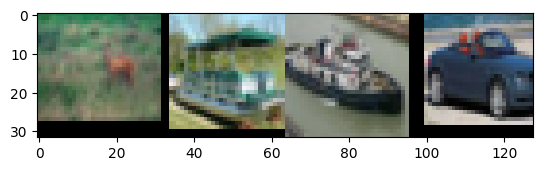

Class labels:  deer  ship  ship  car  


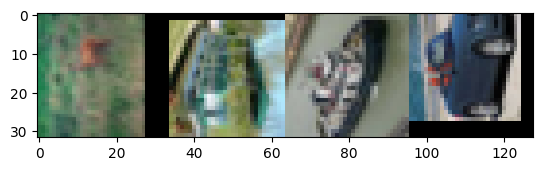

Labels of the rotation:  90    270   90    90   


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat', # CIFAR10 classes
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270') # classes of rotation being considered

def data_vis(img):
    # This code is reversing the normalization we performed above.
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(training_dataloader) # Create dataloader iterator
images, rotated_images, rotation_labels, labels = next(dataiter) # Load a batch from the dataloader

# Displaying the images and labels
print("4")
img_grid = data_vis(torchvision.utils.make_grid(images[:4], padding=0)) # Display the first four images and labels
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = data_vis(torchvision.utils.make_grid(rotated_images[:4], padding=0))
print('Labels of the rotation: ', ' '.join(f'{rot_classes[rotation_labels[j]]:5s}' for j in range(4)))

# Code for evaluating your network

In [ ]:
import time

def run_evaluation(net, test_dataloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    with torch.no_grad(): # We can disable the computation graph storage here since we aren't calculating the gradient at test time
        for images, rotated_images, rotation_labels, classification_labels in test_dataloader:
            if task == 'rotation':
              images, labels = rotated_images.to(device), rotation_labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), classification_labels.to(device)
            # In this section you'll need to run the images through the network and pick the class with max response from classifier
            # loss

            # Codes added here:
            # Forward pass
            outputs = net(images)

            # calculate the batch loss
            loss = criterion(outputs, labels)
            #
            avg_test_loss += criterion(outputs, labels)  / len(test_dataloader)

            # Codes added here:
            # Convert output probabilities to predicted class
            _, predicted = torch.max(outputs.data, 1)
            total +=labels.size(0)
            correct += (predicted == labels).sum().item()
            #

    print('TESTING:')
    print(f'Test set accuracy: {100 * correct / total:.2f} %')
    print(f'Average test loss: {avg_test_loss:.3f}')

In [ ]:
def decay_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Decay learning rate by factor of 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Training for rotation prediction

In this part of the assignment, you'll train a Resnet18 for the rotation prediction task. The network will take in one of your rotated images and predict the label corresponding to that rotation.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # This tells PyTorch to use CUDA if it is available
device

'cpu'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

net = resnet18(num_classes=4) # Pytorch lets you specify the number of classes in this way.
# However, if it didn't you would just modify the network definition to add a linear layer
# PyTorch does this by: self.fc = nn.Linear(512 * block.expansion, num_classes)
net = net.to(device)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.001)

# In this section, you'll need to set your loss function (criterion) and optimizer
# See here (https://pytorch.org/docs/stable/optim.html) for how to use an optimizer
# You'll want to use Cross Entropy Loss as your loss

In [ ]:
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    for epoch in range(num_epochs):
        print(f"Epoch number: {epoch + 1}")

        curr_accum_loss = 0.0
        curr_accum_correct = 0.0
        curr_accum_total = 0.0
        start_time = time.time()

        net.train()

        for i, (images, rotated_images, rotation_label, classification_labels) in enumerate(training_dataloader, 0): # this just returns an iteration count from the dataloader
            decay_learning_rate(optimizer, epoch, init_lr, decay_epochs) # Decay learning rate
            if len(rotated_images) != 128:
              pass # This is for the last minibatch when the data is not a factor of the bach size
            else:
              # You'll need to implement the forward and backward functions and call the optimizer
              # Get the prediction results from the network and store them in the variable below

              if task == 'rotation':
                  images, labels = rotated_images.to(device), rotation_labels.to(device)
              elif task == 'classification':
                  images, labels = images.to(device), classification_labels.to(device)
              else:
                  raise ValueError("Unknown task")

              optimizer.zero_grad()
              predictions = net(images)
              loss = criterion(predictions, labels)
              loss.backward()
              optimizer.step()

              print_freq = 10
              curr_accum_loss += loss.item()

              _, predicted = torch.max(predictions.data, 1)
              curr_accum_total += labels.size(0)
              curr_accum_correct += (predicted == labels).sum().item()

              # calc acc
              curr_accum_total += labels.size(0) # Add the number of predictions to the total (This could be different if your last minibatch is less than batchsize)
              curr_accum_correct += (predicted == labels).sum().item() # Count how many you got right

              if i % print_freq == (print_freq - 1):    # print some statistics
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {curr_accum_loss / print_freq:.3f} acc: {100*curr_accum_correct / curr_accum_total:.2f} time: {time.time() - start_time:.2f}')
                  curr_accum_loss, curr_accum_correct, curr_accum_total = 0.0, 0.0, 0.0
                  start_time = time.time()

        # You'll to run the run_evaluation() function after each epoch.un the run_evaluation() function after each epoch
        # Remember to set the model to evaluation mode
        # Codes added here:
        net.eval()
        run_evaluation(net, test_dataloader, criterion, task)
        #

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

Epoch number: 1
[1,    10] loss: 1.524 acc: 27.42 time: 19.86
[1,    20] loss: 1.540 acc: 26.48 time: 22.06
[1,    30] loss: 1.564 acc: 23.67 time: 20.04
[1,    40] loss: 1.434 acc: 27.03 time: 21.70
[1,    50] loss: 1.433 acc: 26.80 time: 20.81
[1,    60] loss: 1.471 acc: 27.03 time: 21.99
[1,    70] loss: 1.459 acc: 27.34 time: 20.06
[1,    80] loss: 1.511 acc: 26.80 time: 20.79
[1,    90] loss: 1.523 acc: 26.25 time: 20.11
[1,   100] loss: 1.424 acc: 24.69 time: 21.74
[1,   110] loss: 1.456 acc: 26.17 time: 21.10
[1,   120] loss: 1.425 acc: 26.95 time: 25.64
[1,   130] loss: 1.423 acc: 25.08 time: 20.05
[1,   140] loss: 1.436 acc: 27.81 time: 30.97
[1,   150] loss: 1.421 acc: 27.50 time: 20.54
[1,   160] loss: 1.418 acc: 25.78 time: 19.14
[1,   170] loss: 1.418 acc: 26.88 time: 21.10
[1,   180] loss: 1.450 acc: 27.42 time: 19.52
[1,   190] loss: 1.423 acc: 27.97 time: 21.98
[1,   200] loss: 1.411 acc: 28.28 time: 20.02
[1,   210] loss: 1.434 acc: 27.34 time: 19.48
[1,   220] loss: 1

NameError: name 'network_outputs' is not defined

In [ ]:
# Making a new folder in the directory and then saving the model
!mkdir -p model-weights
torch.save(net.state_dict(), "model-weights/model-1-weights")

## Fine-tuning the pre-trained model

### In this section we'll be loading the pre-trained ResNet18 model from the PyTorch library and fine-tune it on the image classification task. However, we're only going to fine-tune part of the model. Specifically, we'll be freezing all the layers except the layer4 block and the fc layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# Load the pre-trained ResNet18 model
net = resnet18(pretrained= True)

# Adding a fc layer with 10 classes at the end
num_classes = 10 # This is 10 because task is "classification"
net.fc = nn.Linear(net.fc.in_features, num_classes)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.9MB/s]


In [ ]:
# We need to write code here to freeze all layers except the layer4 block and the fc layer.
for param in net.parameters():
    param.requires_grad = False

for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Here we'll list the parameters that are being trained to make sure we did the above correctly
parameter_to_train = net.parameters()
print("Parameters that will be trained:")
parameter_to_train = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        parameter_to_train.append(param)
        print("\t",name)

Parameters that will be trained:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# Again, set the loss function and optimizer. Remember, your optimizer only will update the trainable parameters.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameter_to_train, lr= 0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=2, decay_epochs=10, init_lr=0.01, task='classification')

Epoch number: 1
[1,    10] loss: 3.439 acc: 17.58 time: 16.85
[1,    20] loss: 2.342 acc: 30.31 time: 13.61
[1,    30] loss: 1.951 acc: 35.86 time: 14.02
[1,    40] loss: 1.679 acc: 44.77 time: 12.21
[1,    50] loss: 1.535 acc: 47.58 time: 13.18
[1,    60] loss: 1.626 acc: 44.92 time: 13.32
[1,    70] loss: 1.501 acc: 49.77 time: 12.99
[1,    80] loss: 1.501 acc: 52.50 time: 13.42
[1,    90] loss: 1.519 acc: 51.17 time: 13.35
[1,   100] loss: 1.484 acc: 53.52 time: 13.42
[1,   110] loss: 1.427 acc: 52.81 time: 13.41
[1,   120] loss: 1.308 acc: 52.58 time: 13.01
[1,   130] loss: 1.340 acc: 54.45 time: 12.59
[1,   140] loss: 1.314 acc: 54.69 time: 12.55
[1,   150] loss: 1.317 acc: 57.34 time: 11.88
[1,   160] loss: 1.328 acc: 57.11 time: 11.76
[1,   170] loss: 1.278 acc: 57.03 time: 12.90
[1,   180] loss: 1.290 acc: 55.39 time: 12.72
[1,   190] loss: 1.259 acc: 56.33 time: 13.07
[1,   200] loss: 1.209 acc: 58.67 time: 12.61
[1,   210] loss: 1.258 acc: 57.97 time: 12.87
[1,   220] loss: 1

In [ ]:
# Saving the model
torch.save(net.state_dict(), "model-weights/model-2-weights")

# Fine-tuning a randomly initialized model

### In this part, we need to randomly initialize a ResNet18 model. Then, we'll train that model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# Load a randomly initialized ResNet18 network
net = resnet18(pretrained=False)
# Adding a fc layer with 10 classes at the end
num_classes = 10 # This is 10
net.fc = nn.Linear(net.fc.in_features, num_classes)

In [ ]:
# You'll need to freeze all layers in the network except the layer4 block and the fc layer (only these should be trainable)
# Hint: Look up the "requires_grad" variable
for param in net.parameters():
    param.requires_grad = False

for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
parameter_to_train = net.parameters()
print("Parameters that will be trained:")
parameter_to_train = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        parameter_to_train.append(param)
        print("\t",name)

Parameters that will be trained:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# Again, set the loss function and optimizer. Remember, your optimizer only will update the trainable parameters.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameter_to_train, lr= 0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

Epoch number: 1
[1,    10] loss: 2.060 acc: 26.48 time: 17.95
[1,    20] loss: 2.066 acc: 25.55 time: 15.40


KeyboardInterrupt: 

In [ ]:
# Saving the model
torch.save(net.state_dict(), "model-weights/model-3-weights")

# Supervised training

### In this part, you'll load the pre-trained ResNet18 and fine-tune the whole model on the CIFAR10 classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# Load the ResNet18 model (pretrained)
net = resnet18(pretrained= True)

# Adding a fc layer with 10 classes at the end of the model
num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes)

In [ ]:
# Again, set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

Epoch number: 1
[1,    10] loss: 3.564 acc: 9.53 time: 20.60
[1,    20] loss: 2.710 acc: 11.17 time: 18.06


KeyboardInterrupt: 

In [ ]:
# Saving the model
torch.save(net.state_dict(), "model-weights/model-4-weights")

# Supervised training the randomly initialized model

### Below, you'll randomly initialize a ResNet18 and train the whole model on the classification task.

In [ ]:
# Randomly initialize a ResNet18 and train the whole model on the classification task

net = resnet18(pretrained=False)

# Adding a fc layer with 10 classes at the end of the model
num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes)
# Again, set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.001)
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# Randomly initialize the ResNet18 model
net = resnet18(pretrained= False)

# Adding a fc layer withh 10 classes at the end of the model
num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes)

In [ ]:
# Again, set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

Epoch number: 1
[1,    10] loss: 3.450 acc: 9.38 time: 21.62
[1,    20] loss: 2.634 acc: 14.22 time: 19.76
[1,    30] loss: 2.307 acc: 18.83 time: 21.53
[1,    40] loss: 2.264 acc: 20.08 time: 22.99
[1,    50] loss: 2.192 acc: 22.66 time: 21.61
[1,    60] loss: 2.103 acc: 23.52 time: 24.69
[1,    70] loss: 2.076 acc: 27.27 time: 18.31
[1,    80] loss: 2.006 acc: 30.86 time: 21.93
[1,    90] loss: 2.080 acc: 25.08 time: 19.44
[1,   100] loss: 1.905 acc: 29.38 time: 20.37


KeyboardInterrupt: 

In [ ]:
# Saving the model
torch.save(net.state_dict(), "model-weights/model-5-weights")